In [18]:
expid='MC_C_20250330_000050'
sensor='R00_SG1'

In [19]:
from lsst.resources import ResourcePath
from astropy.io import fits
import os
import numpy
from astropy.table import Table
from dateutil.parser import parse
import re
import json
import matplotlib.pyplot as plt

#MC_C_20240918_000019_R40_SG1_guider.fits
prefix = 'MC_C_'
p = re.compile( rf'{prefix}(\d*)_(\d*)_(R.._S..)_guider.fits' )


In [20]:
def examineone(fname):
    date, seqnum, sensor = p.match(fname).groups()
    path = f's3://embargo@rubin-summit/LSSTCam/{date}/{prefix}{date}_{seqnum}/{fname}'
    rp=ResourcePath(path)
    with rp.open(mode="rb") as f:
        hdu_list = fits.open(f)
    hdus = hdu_list[2::2]  # for the mode with raw stamps
#    hdus = hdu_list[1:]   # for the mode without raw stamps
    timing = [ parse(hdu.header['STMPTIME']) for hdu in hdus ]
    mean = [ numpy.mean(hdu.data) for hdu in hdus ]
    stdnoise = numpy.mean(list(map( lambda x: numpy.std(x.data), hdus))[1:]) 
    stdstdnoise = numpy.std(list(map( lambda x: numpy.std(x.data), hdus))[1:]) 
    hz = 1/numpy.mean(numpy.diff(list(map( lambda x: parse(x.header['STMPTIME']), hdus) )[1:])).total_seconds()
    
    return {
        's3path': rp,
        'basename': rp.abspath().basename(),
        'noise': stdnoise,
        'std(noise)': stdstdnoise,        
        'Hz': hz,
        'mean': mean,
        'timing': timing
    }
    

In [21]:
table=Table(
    list(map( lambda x: examineone(x), [
        f'{expid}_R00_SG0_guider.fits',
        f'{expid}_R00_SG1_guider.fits',
        f'{expid}_R04_SG0_guider.fits',
        f'{expid}_R04_SG1_guider.fits',
        f'{expid}_R40_SG0_guider.fits',
        f'{expid}_R40_SG1_guider.fits',
        f'{expid}_R44_SG0_guider.fits',
        f'{expid}_R44_SG1_guider.fits'
    ])
       )
)
table['basename','noise','std(noise)','Hz','mean','timing']

basename,noise,std(noise),Hz,mean,timing
str40,float64,float64,float64,float64[69],object[69]
MC_C_20250330_000050_R00_SG0_guider.fits,8.155072557191033,0.06026879894410592,4.645027034057338,14831.0984 .. 14831.1248,2025-03-30 18:14:04 .. 2025-03-30 18:14:18.639000
MC_C_20250330_000050_R00_SG1_guider.fits,23.12474165410836,0.05064041787435869,4.645027034057338,14645.1488 .. 14644.912,2025-03-30 18:14:04 .. 2025-03-30 18:14:18.639000
MC_C_20250330_000050_R04_SG0_guider.fits,4.094886930207973,0.08963315097160733,4.645027034057338,14957.6936 .. 14957.9936,2025-03-30 18:14:04 .. 2025-03-30 18:14:18.639000
MC_C_20250330_000050_R04_SG1_guider.fits,4.465014725516134,0.08825966892846988,4.645027034057338,14981.1736 .. 14980.8268,2025-03-30 18:14:04 .. 2025-03-30 18:14:18.639000
MC_C_20250330_000050_R40_SG0_guider.fits,5.54405339671819,0.0617180323241941,4.645027034057338,14882.5904 .. 14883.1416,2025-03-30 18:14:04 .. 2025-03-30 18:14:18.639000
MC_C_20250330_000050_R40_SG1_guider.fits,13.218675247366102,0.04789108931129105,4.645027034057338,15166.8952 .. 15166.8508,2025-03-30 18:14:04 .. 2025-03-30 18:14:18.639000
MC_C_20250330_000050_R44_SG0_guider.fits,5.858300749731419,0.052863429390166035,4.645027034057338,14935.5624 .. 14935.76,2025-03-30 18:14:04 .. 2025-03-30 18:14:18.639000
MC_C_20250330_000050_R44_SG1_guider.fits,6.097456033644662,0.0822739477367259,4.645027034057338,15074.5224 .. 15074.372,2025-03-30 18:14:04 .. 2025-03-30 18:14:18.639000


In [22]:
for row in table:
    plt.plot(row['timing'],row['mean'],'.',label=row['basename'])
plt.legend()

In [23]:
rp = ResourcePath(table[1]['s3path'].geturl().replace('.fits','.json'))
with rp.open(mode="r") as f:
    j=json.load(f)
print(json.dumps(j,indent=2))

{
  "__CONTENT__": "metadata",
  "SIMPLE": true,
  "BITPIX": 8,
  "NAXIS": 0,
  "EXTEND": true,
  "BINX": 1,
  "BINY": 1,
  "CCDGAIN": 1.0,
  "CCDNOISE": 10.0,
  "DETSIZE": "[1:4072,1:4000]",
  "DATE": "2025-03-30T18:14:04.370",
  "MJD": 60764.75977280177,
  "IMGTYPE": "UNKNOWN",
  "OBSID": "MC_C_20250330_000050",
  "BUNIT": "adu",
  "TIMESYS": "TAI",
  "INSTRUME": "lsstCam",
  "TELESCOP": "Simonyi Survey Telescope",
  "OBS-LONG": null,
  "OBS-LAT": null,
  "OBS-ELEV": null,
  "OBSGEO-X": null,
  "OBSGEO-Y": null,
  "OBSGEO-Z": null,
  "RA": null,
  "DEC": null,
  "RASTART": null,
  "DECSTART": null,
  "RAEND": null,
  "DECEND": null,
  "ROTPA": null,
  "ROTCOORD": null,
  "HASTART": null,
  "ELSTART": null,
  "AZSTART": null,
  "AMSTART": null,
  "HAEND": null,
  "ELEND": null,
  "AZEND": null,
  "AMEND": null,
  "TRACKSYS": null,
  "RADESYS": null,
  "FOCUSZ": null,
  "OBJECT": null,
  "VIGNETTE": null,
  "VIGN_MIN": null,
  "CAMCODE": "MC",
  "CONTRLLR": "C",
  "DAYOBS": "20250330",

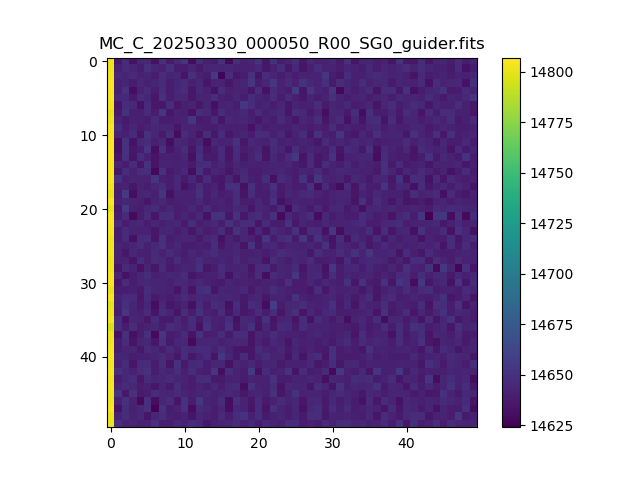

In [24]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from astropy.io import fits
from IPython.display import HTML
%matplotlib widget

with table[table['basename']==f'{expid}_{sensor}_guider.fits']['s3path'][0].open(mode='rb') as f:
    fh = fits.open(f)

fig, ax = plt.subplots()

frames = [[plt.imshow(img.data, animated=True)] for img in fh[2::2]]
plt.colorbar()
plt.title(table[0]['basename'])
ani = animation.ArtistAnimation(fig, frames, interval=120, blit=True, repeat_delay=1000)

HTML(ani.to_html5_video())
#plt.show()